In [38]:
import pandas as pd
import numpy as np
import seaborn as sns

import pickle
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline

from gensim import corpora, models, similarities, matutils

import re
import string

from wordcloud import WordCloud, STOPWORDS

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors



# call glove2word2vec script
# default way (through CLI): python -m gensim.scripts.glove2word2vec --input <glove_file> --output <w2v_file>
from gensim.scripts.glove2word2vec import glove2word2vec

In [39]:
# glove_file = datapath('/Users/robinleoknauth/downloads/glove/glove.6B.300d.txt')
# tmp_file = get_tmpfile("glove_word2vec.txt")

# glove2word2vec(glove_file, tmp_file)

# model = KeyedVectors.load_word2vec_format(tmp_file)

In [49]:
df_transcripts = pd.read_csv('./data/transcripts.csv')
df_main = pd.read_csv('./data/ted_main.csv')

In [50]:
df_transcripts.head(3)

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...


In [51]:
df_merged = df_main.merge(df_transcripts, on = 'url' )

## Preprocessing the text

In [52]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
clean_parens = lambda x: re.sub(r'\([^)]+\)', ' ', x)

df_merged['text'] = df_merged.transcript.map(clean_parens).map(punc_lower).map(alphanumeric)
# df_merged['text'] = df_merged.transcript.map(alphanumeric)
# df_merged['text'] = df_merged.transcript.map(punc_lower)


### Pickle

Note: GitHub doesn't allow uploads of pickles that are bigger than 100MB, so I omitted the steps of creating the columns with the lemmatized and tokenized text here. Logically they should be here, this is a workaround for now.


In [55]:
df_merged.to_pickle("./data/df_merged_cleaned.pkl")

### Tokenization
Note: GitHub doesn't allow uploads of pickles that are bigger than 100MB, so I omitted the steps of creating the columns with the lemmatized and tokenized text here. Logically they should be here, this is a workaround for now

In [53]:
stop_words = set(stopwords.words('english'))

In [45]:
df_merged['tokenized_text'] = df_merged['text'].apply(word_tokenize)

In [46]:
df_merged['tokenized_text'] = df_merged['tokenized_text'].apply(lambda x: [word for word in x if word not in stop_words])

## Lemmatization


In [47]:
lemmatizer=WordNetLemmatizer()


df_merged['lemmatized_text'] = df_merged['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [48]:
df_merged['lemma_text_string'] = df_merged['lemmatized_text'].apply(', '.join)

## WordCloud for Visualization

In [19]:
'''
considering only 1-grams
cut words present in less than 5% of documents
cut words present in more than 33% of documents
'''


vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1),
                        min_df = 0.05,
                        max_df = 0.40)

In [35]:
tfidf = vectorizer.fit_transform(df_merged['lemma_text_string'])

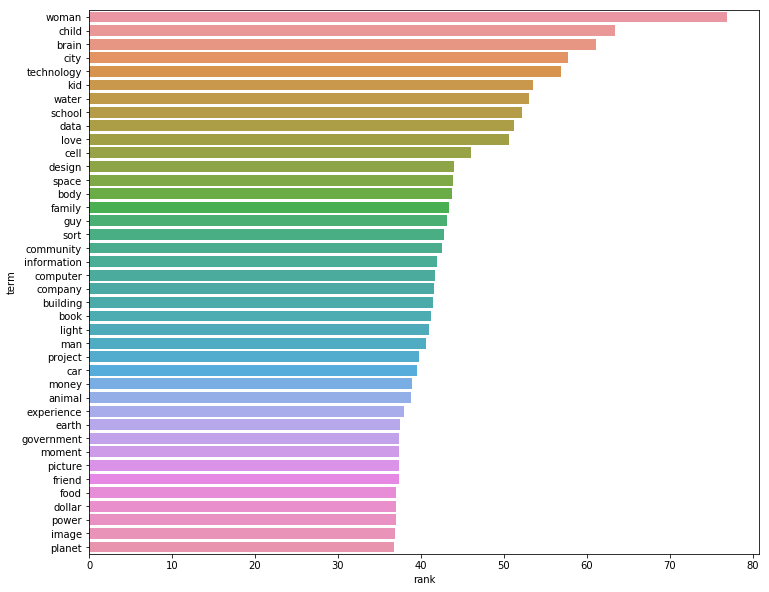

In [36]:
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

ranked = rank_words(terms = vectorizer.get_feature_names(), feature_matrix = tfidf)

fig, ax = plt.subplots(figsize=(12,10), ncols=1, nrows=1)
sns.barplot(x ='rank', y ='term', data = ranked[:40], ax=ax);

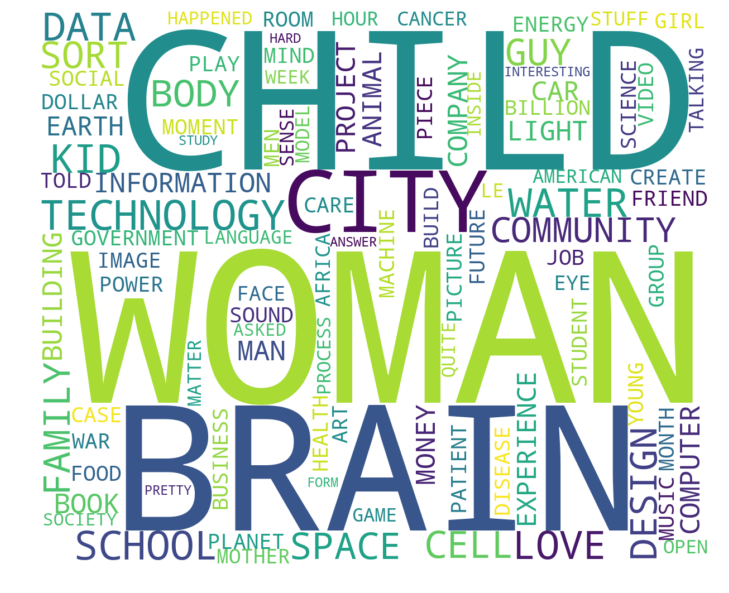

In [37]:
dic = {ranked.loc[i,'term'].upper(): ranked.loc[i,'rank'] for i in range(0,len(ranked))}

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      width=1200,
                      height=1000).generate_from_frequencies(dic)
fig = plt.figure(1,figsize=(12,15))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()